torch.Size([1, 1, 128, 128])


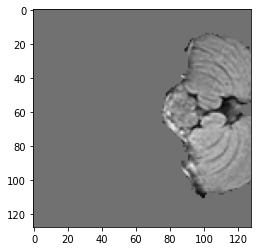

In [18]:
from cProfile import label
from cv2 import norm
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import os
import nibabel as nib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from random import randint
import monai.transforms as transforms

class BratsTrainDataset(Dataset):
    def __init__(self, datapath='/mnt/asgard2/data/lingkai/braTS20/BraTS2020_TrainingData', augmentation=None):
        self.augmentaion = augmentation
        self.folderpaths = {
            'seg': os.path.join(datapath, 'labels/'),
            'flair': os.path.join(datapath, 'flair/')
        }

    def __getitem__(self, index):
        images = {}
        for name in self.folderpaths:
            img = nib.load(os.path.join(self.folderpaths[name], f'BraTS20_Training_{str(index+1).zfill(3)}_{name}.nii')).get_fdata()
            # img = np.array(img.dataobj)
            if name == 'seg':
                img[img==4] = 3
            # img = Image.fromarray(img.astype('uint8'), 'RGB')
            images[name] = img

        if self.augmentaion:
            images = self.augmentaion(image=images['flair'],mask=images['seg'])
        # normalize the non-zero voxels in images
        images['flair'] = self.normalize(images['flair'])
        # images = self.crop(images)
        flair_slice, label_slice = self.get_slice(images)
        flair_slice, label_slice = self.crop_center(flair_slice), self.crop_center(label_slice)
        return np.expand_dims(flair_slice, axis=0), np.expand_dims(label_slice, axis=0)

    def __len__(self):
        return len(os.listdir(self.folderpaths['seg'])) - 1
    
    def crop_center(self, img, cropx=128, cropy=128):
        y, x = img.shape
        startx = x//2 - cropx//2
        starty = y//2 - cropy//2    
        return img[starty:starty+cropy, startx:startx+cropx]


    def normalize(self, input):
        normalizeIntensity = transforms.NormalizeIntensity(nonzero=True)
        input_norm = normalizeIntensity(input)
        return input_norm

    def get_slice(self, images):
        _, _, max_z = images['flair'].shape
        slice_z_num = randint(0, max_z-1)
        return images['flair'][:, :, slice_z_num], images['seg'][:, :, slice_z_num]


        
    

train_dataset = BratsTrainDataset()
train_loader = DataLoader(train_dataset, batch_size=1, num_workers=1, shuffle=True)
a, b = next(iter(train_loader))
plt.imshow(a[0, 0, :, :], cmap='gray')
print(a.shape)


    # def crop(self, images):
    #     cropForeground = transforms.CropForegroundd(keys=["flair", 'seg'], source_key='flair')
    #     centerSpatialCrop = transforms.CenterSpatialCropd(keys=['flair', 'seg'], roi_size=(100, 100))
    #     images = cropForeground(images)
    #     images = centerSpatialCrop(images)
    #     # bbox = transforms.utils.generate_spatial_bounding_box(images['flair'])
    #     # flair = transforms.SpatialCrop(roi_center=bbox[0], roi_end=bbox[1])(flair)
    #     # label = transforms.SpatialCrop(roi_center=bbox[0], roi_end=bbox[1])(label)
        
    #     # return flair, label
    #     return images

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


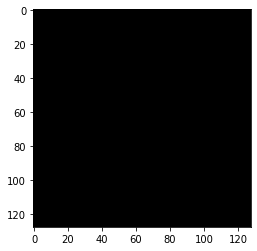

In [19]:
plt.imshow(b[0, 0, :, :], cmap='gray')

print(b[0, 0, :, :] == 1)